In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split



In [2]:
train_data = pd.read_csv('/home/vatsal/Downloads/criminal_train.csv')
test_data = pd.read_csv('/home/vatsal/Downloads/criminal_test.csv')

In [3]:
train_data.head(2)

,PERID,IFATHER,NRCH17_2,IRHHSIZ2,IIHHSIZ2,IRKI17_2,IIKI17_2,IRHH65_2,IIHH65_2,PRXRETRY,...,TOOLONG,TROUBUND,PDEN10,COUTYP2,MAIIN102,AIIND102,ANALWT_C,VESTR,VEREP,Criminal
0,25095143,4,2,4,1,3,1,1,1,99,...,1,2,1,1,2,2,3884.805998,40026,1,0
1,13005143,4,1,3,1,2,1,1,1,99,...,2,2,2,3,2,2,1627.108106,40015,2,1


In [4]:
mms = MinMaxScaler()
x_train = mms.fit_transform(train_data.drop('Criminal',axis=1))
x_test = mms.transform(test_data)


In [5]:
x_train.shape

(45718, 71)

In [6]:
from sklearn.decomposition import PCA

In [7]:
pca = PCA(n_components=22)

In [8]:
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

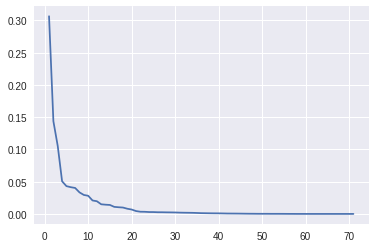

In [68]:
import numpy as np
plt.plot(np.arange(1,72),pca.explained_variance_ratio_)

In [9]:
x_train,x_train_test,y_train,y_train_test = train_test_split(x_train,train_data.Criminal,test_size=0.2)

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

Using TensorFlow backend.


In [11]:
import keras.backend as K
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [17]:
def build_clf():
    myclf = Sequential()
    myclf.add(Dense(22,input_dim=22,activation='relu'))
    myclf.add(Dropout(0.1))
    myclf.add(Dense(22,input_dim=22,activation='relu'))
    myclf.add(Dropout(0.1))
    myclf.add(Dense(1,activation='sigmoid'))
    myclf.compile(optimizer='adam',loss='binary_crossentropy',metrics=[matthews_correlation])
    return myclf

In [18]:
kclf = KerasClassifier(build_fn=build_clf,batch_size=32,epochs=1)
# accuracy = cross_val_score(estimator=kclf,X=x_train,y=y_train,cv=10,verbose=3)

In [19]:
kclf.fit(x_train,y_train,batch_size=32,epochs=20)

Epoch 1/20
36574/36574 [==============================] - 3s - loss: 0.1973 - matthews_correlation: 0.1125     
Epoch 2/20
36574/36574 [==============================] - 3s - loss: 0.1268 - matthews_correlation: 0.4028     
Epoch 3/20
36574/36574 [==============================] - 3s - loss: 0.1201 - matthews_correlation: 0.4410     
Epoch 4/20
36574/36574 [==============================] - 3s - loss: 0.1170 - matthews_correlation: 0.4467     
Epoch 5/20
36574/36574 [==============================] - 3s - loss: 0.1133 - matthews_correlation: 0.4702     
Epoch 6/20
36574/36574 [==============================] - 3s - loss: 0.1120 - matthews_correlation: 0.4913     
Epoch 7/20
36574/36574 [==============================] - 3s - loss: 0.1102 - matthews_correlation: 0.4923     
Epoch 8/20
36574/36574 [==============================] - 3s - loss: 0.1102 - matthews_correlation: 0.4958     
Epoch 9/20
36574/36574 [==============================] - 3s - loss: 0.1096 - matthews_correlation: 0.50

In [20]:
yp = kclf.predict(x_train_test)

8800/9144 [===========================>..] - ETA: 0s

In [21]:
from sklearn.metrics import matthews_corrcoef

In [22]:
matthews_corrcoef(y_train_test,yp)

0.60200353151867325

In [90]:
from sklearn.ensemble import RandomForestClassifier
myrclf = RandomForestClassifier()
myrclf.fit(x_train,y_train)
yp = myrclf.predict(x_train_test)

In [91]:
matthews_corrcoef(y_train_test,yp)

0.4882350635898059